### Generate MNIST handwritten digits by using GAN

- 필기체 숫자를 생성할 수 있는 간단한 GAN
- Tensorflow Keras 데이터셋을 사용해 MNIST 데이터에 접근
- 데이터의 크기는 28*28 크기이며 60,000개의 훈련 데이터 포함
- 숫자의 픽셀 값은 0~255 사이로 이를 [-1, 1] 사이의 값으로 정규화함
- 생성기와 판별기의 아키텍쳐는 다층퍼셉트론(Multilayer Perceptron)으로 구성
    - 생성기의 출력층의 크기는 784


In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers


import matplotlib.pyplot as plt

import sys

import numpy as np
import tqdm



In [2]:
# 훈련 데이터 로드
# Load MNIST data
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)



In [3]:
# 생성기 노이즈 입력 설정
# Set the seed for reproducible result
np.random.seed(1000)

randomDim = 10 

### Generator's architecture


- LeakyReLu 활성화함수 사용(음의 값을 약간 허용)
- 256, 512, 1024개의 은닉층으로 구성
- 출력층은 784개 뉴런으로 설정

In [5]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

generator = Sequential()
generator.add(Dense(256, input_dim=randomDim)) #, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
#generator.compile(loss='binary_crossentropy', optimizer=adam)

### Discriminator's architecture


- 훈련 데이터나 생성기가 만든 이미지를 가져옴
- 판별기의 출력은 단일 비트로 0 (fake) 또는 1 (real)

In [6]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

### 생성기와 판별기 결합하여 GAN 구성

- trainable 인수를 False로 설정하여 판별기 가중치 고정
- 판별기를 따로 훈련시키고 판별기의 손실 함수로 binary-crossentropy 함수 사용
- 이후 판별기의 가중치를 동결하고 결합된 GAN을 training하여 생성기를 학습
    - 판별기와 같은 binary-crossentropy 함수임
    

In [7]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []

### 필기체 숫자의 손실과 생성된 이미지를 표시

In [9]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def saveGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

### Training

- 에폭마다 랜덤 노이즈 샘플을 먼저 생성기에 공급
- 생성된 가짜 이미지와 실제 훈련 이미지를 특정 레이블과 함께 배치
- 주어진 배치에서 판별기를 먼저 훈련

In [10]:
def train(epochs=1, batchSize=128):
    batchCount = int(X_train.shape[0] / batchSize)
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # 랜덤 입력 노이즈와 이미지를 얻는다.
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]
            
            # 가짜 MNIST 이미지 생성
            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])
            
            # 생성된 것과 실제 이미지의 레이블
            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # 편파적 레이블 평활화(One-sided label smoothing)
            yDis[:batchSize] = 0.9
            
            # 판별기 훈련
            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # 생성기 훈련
            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # 이 에폭의 최근 배치에서의 손실 저장
        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 20 == 0:
            saveGeneratedImages(e)
            

    # Plot losses from every epoch
    plotLoss(e)

Epochs: 10
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------
--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------


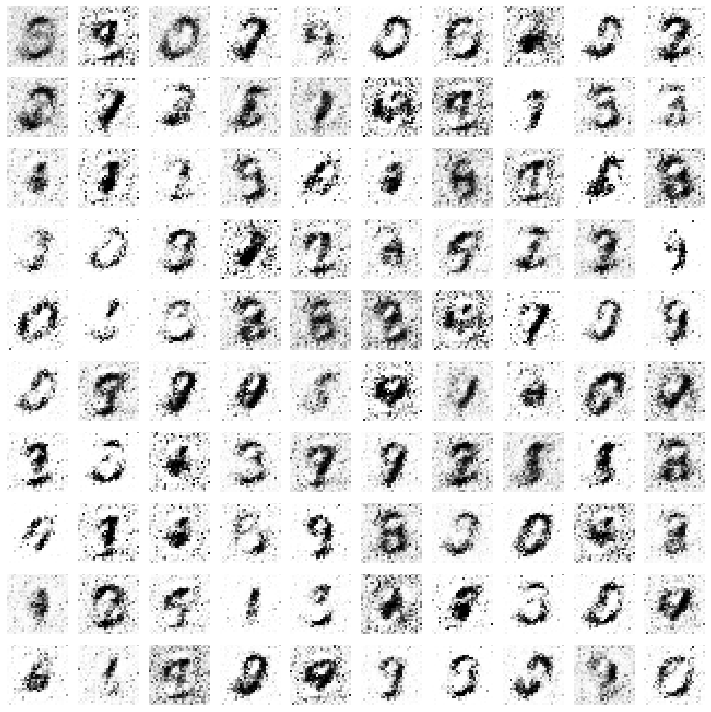

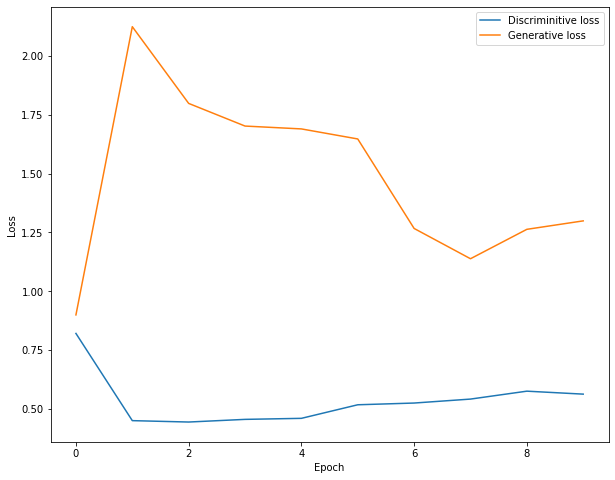

In [11]:
train(10, 128)

### 심층 컨볼루션 GAN (DCGAN)

- 2016년 제안된 DCGAN은 가장 인기 있고 성공적인 GAN 아키텍처 중 하나임
- 핵심 아이디어는 풀링 계층이나 최종 분류기 계층 없이 컨볼루션 계층을 사용하는 것
- 컨볼루션 스트라이드와 전치 컨볼루션을 사용해 이미지의 다운샘플링과 업샘플링 수행
- 그래디언트의 흐름을 돕고자 각 컨볼루션 계층 다음에 배치 정규화를 수행

In [12]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class DCGAN():
    def __init__(self, rows, cols, channels, z = 10):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=256, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # 적대적 참의 정의(Adversarial ground truths)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  판별기 훈련(Train Discriminator)
            # ---------------------

            # 임의로 이미지 반을 선택
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # 노이즈를 샘플링해 새로운 이미지의 배치 생성
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  생성기 훈련(Train Generator)
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/dcgan_mnist_%d.png" % epoch)
        plt.close()

In [14]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=100, batch_size=256, save_interval=50)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 64)         

65 [D loss: 0.782937, acc.: 55.47%] [G loss: 1.486783]
66 [D loss: 0.975270, acc.: 41.99%] [G loss: 1.278498]
67 [D loss: 1.054255, acc.: 37.89%] [G loss: 1.186803]
68 [D loss: 1.057088, acc.: 36.72%] [G loss: 1.057535]
69 [D loss: 1.059284, acc.: 33.40%] [G loss: 1.023845]
70 [D loss: 0.943354, acc.: 42.19%] [G loss: 0.982233]
71 [D loss: 0.912407, acc.: 43.55%] [G loss: 1.040244]
72 [D loss: 0.841008, acc.: 46.88%] [G loss: 1.089157]
73 [D loss: 0.803618, acc.: 50.00%] [G loss: 1.124764]
74 [D loss: 0.826168, acc.: 51.56%] [G loss: 1.149770]
75 [D loss: 0.783411, acc.: 55.27%] [G loss: 1.109916]
76 [D loss: 0.856424, acc.: 47.85%] [G loss: 1.164758]
77 [D loss: 0.806721, acc.: 52.15%] [G loss: 1.200937]
78 [D loss: 0.873155, acc.: 50.00%] [G loss: 1.133536]
79 [D loss: 0.899708, acc.: 40.04%] [G loss: 1.064778]
80 [D loss: 0.963121, acc.: 40.43%] [G loss: 1.038894]
81 [D loss: 0.888462, acc.: 46.29%] [G loss: 1.083678]
82 [D loss: 0.883195, acc.: 44.14%] [G loss: 1.156167]
83 [D loss

In [27]:
dcgan.save_imgs(epoch=100)